# Data exploration of scientific literature on neurological disorders

In [1]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
import numpy as np
import string

In [2]:
data = pd.read_csv('migraine.csv', index_col = 'date',  parse_dates = True).drop(columns = 'id')

In [3]:
total_time = (data.sort_values('date').index[0]-data.sort_values('date').index[-1])

In [4]:
total_time

Timedelta('-2722 days +00:00:00')

In [5]:
data.head()

,citations,authors,published in,title,abstract
date,,,,,
2018-06-28,NaN,"Hsiangkuo Yuan, Clinton G Lauritsen, Eric A Ka...","BioDrugs : clinical immunotherapeutics, biopha...",CGRP Monoclonal Antibodies for Migraine: Ratio...,"Calcitonin gene-related peptide (CGRP), a neur..."
2018-06-22,NaN,"Mariagrazia D'Ippolito, Marco Tramontano, Mari...",The Journal of the American Osteopathic Associ...,Effects of Osteopathic Manipulative Therapy on...,The substantial functional impairment associat...
2018-06-22,NaN,"F Qiu, D D Song, Q F Guo, Q Q Wang, Z W Wang, ...",Zhonghua yi xue za zhi,[Analysis of the clinical features of vestibul...,Conclusions: The vestibular migraine patients ...
2018-06-19,"Cephalalgia. 2000 Jun;20(5):486-508, Neurology...","M de Tommaso, M Delussi",Functional neurology,Nociceptive blink reflex habituation biofeedba...,Reduced habituation of the nociceptive blink r...
2018-06-18,NaN,"Machaon Bonafede, Qian Cai, Katherine Cappell,...",Journal of managed care & specialty pharmacy,Factors Associated with Direct Health Care Cos...,Migraine imposes substantial economic burden o...


### We need network/graph analysis on the authors and the citations

In [6]:
data.authors = data.authors.str.split(', ')

In [7]:
authors = [l for n in data.authors.tolist() for l in n]

In [8]:
authors[:10]

['Hsiangkuo Yuan',
 'Clinton G Lauritsen',
 'Eric A Kaiser',
 'Stephen D Silberstein',
 "Mariagrazia D'Ippolito",
 'Marco Tramontano',
 'Maria Gabriella Buzzi',
 'F Qiu',
 'D D Song',
 'Q F Guo']

In [9]:
author_count = Counter(authors)

In [10]:
author_count.most_common(10)

[('Richard B Lipton', 38),
 ('Dawn C Buse', 26),
 ('Peter J Goadsby', 23),
 ('Messoud Ashina', 17),
 ('Michael L Reed', 15),
 ('Tobias Kurth', 15),
 ('Gisela M Terwindt', 15),
 ('Todd J Schwedt', 14),
 ('Michel D Ferrari', 14),
 ('David W Dodick', 13)]

### Thoughts about what kind of info we need from the abstracts 
* Visualize how word choice changes over time?
* identify key words that are used when a breakthrough is happening or not?
  * This seems too complex
* look for words like 'treatment' and 'cure'
  * changes in these words over time?  
  
__Authors are never going to publish that they still haven't found a cure. So how do we identify actual progress?__


These are copied functions to cluster on documents. 

In [11]:
def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    # text = text.lower()
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

In [12]:
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.6,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return km_model, tfidf_model, vectorizer.get_feature_names()
 

In [13]:
km_model, tfidf_model, terms = cluster_texts(data.abstract.tolist(), 5)

In [14]:
terms[100]

'intens'

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [16]:
# num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2


In [17]:
labels = km_model.fit_predict(tfidf_model)

In [18]:
X = tfidf_model.todense()

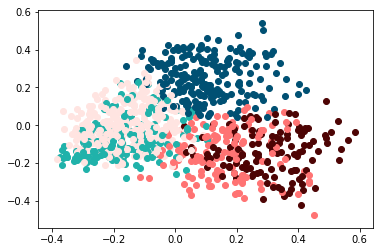

In [19]:
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

In [20]:
# t-SNE plot
embeddings = TSNE(learning_rate = 10)
Y = embeddings.fit_transform(X)


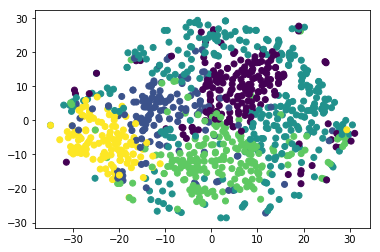

In [21]:
plt.scatter(Y[:, 0], Y[:, 1], c = labels)
plt.show()

In [22]:
data['labels'] = labels

In [34]:
data.head(5)

,citations,authors,published in,title,abstract,labels
date,,,,,,
2018-06-28,NaN,"[Hsiangkuo Yuan, Clinton G Lauritsen, Eric A K...","BioDrugs : clinical immunotherapeutics, biopha...",CGRP Monoclonal Antibodies for Migraine: Ratio...,"Calcitonin gene-related peptide (CGRP), a neur...",2
2018-06-22,NaN,"[Mariagrazia D'Ippolito, Marco Tramontano, Mar...",The Journal of the American Osteopathic Associ...,Effects of Osteopathic Manipulative Therapy on...,The substantial functional impairment associat...,4
2018-06-22,NaN,"[F Qiu, D D Song, Q F Guo, Q Q Wang, Z W Wang,...",Zhonghua yi xue za zhi,[Analysis of the clinical features of vestibul...,Conclusions: The vestibular migraine patients ...,2
2018-06-19,"Cephalalgia. 2000 Jun;20(5):486-508, Neurology...","[M de Tommaso, M Delussi]",Functional neurology,Nociceptive blink reflex habituation biofeedba...,Reduced habituation of the nociceptive blink r...,0
2018-06-18,NaN,"[Machaon Bonafede, Qian Cai, Katherine Cappell...",Journal of managed care & specialty pharmacy,Factors Associated with Direct Health Care Cos...,Migraine imposes substantial economic burden o...,4


In [24]:
data_s = data.sort_values(by = 'labels', axis = 0)

In [25]:
def mode(row):
    names = [l for n in row.authors.tolist() for l in n]
    mc = Counter(names).most_common(2)
    return list([mc])

In [26]:
data_s.groupby(by = 'labels').agg(mode)['authors']

labels
0    [(Richard B Lipton, 12), (Stephen D Silberstei...
1             [(Dawn C Buse, 5), (Sepideh F Varon, 5)]
2          [(Peter J Goadsby, 9), (Messoud Ashina, 8)]
3     [(Richard B Lipton, 11), (Catherine D Chong, 7)]
4      [(Michelle A Williams, 7), (B Lee Peterlin, 6)]
Name: authors, dtype: object

## Use a journal ranking metric for finding fraction of papers in top journals

In [27]:
journals = data_s['published in'].tolist()

In [28]:
scimago = pd.read_excel('scimagojr 2017  Subject Category - Neurology (clinical).xlsx')

SJR is 'scimago journal rankings'
let's say a publication in a top-ranking journal is more likely to be a breakthrough.
take the top, say, 15 journals from the 'neurology' SJR and add 'Science', 'Nature', 'New England Journal of Medicine', 'Cell', 'Nature Medicine' (more?)

In [29]:
top_neur_jr = scimago.Title[scimago.SJR > 3].tolist()

In [30]:
top_neur_jr.extend(['Science', 'Nature', 'Cell', 'Nature Medicine', 'New England Journal of Medicine'])

In [31]:
top_neur_jr

['The Lancet Neurology',
 'Acta Neuropathologica',
 'Brain',
 'Annals of Neurology',
 'Nature Reviews Neurology',
 'JAMA Neurology',
 "Alzheimer's and Dementia",
 'Neuro-Oncology',
 'Stroke',
 'Molecular Neurodegeneration',
 'Neurology',
 'Sleep Medicine Reviews',
 'Journal of Neurology, Neurosurgery and Psychiatry',
 'Movement Disorders',
 'Neuroscientist',
 'Science',
 'Nature',
 'Cell',
 'Nature Medicine',
 'New England Journal of Medicine']

In [32]:
def in_top_jr(row):
    return row in top_neur_jr

In [33]:
data_s['published in'].apply(in_top_jr).sum()

15